In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [7]:
train_dir = 'data/iciar/train/'
test_dir = "data/iciar/test/"

extracted_features_dir = "extracted_features/"
model_name = "Reinhard_Xception_concate"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/iciar/train/ 0
data/iciar/train/carcinoma 2310
data/iciar/train/non-carcinoma 2310
******************************
data/iciar/test/ 0
data/iciar/test/carcinoma 50
data/iciar/test/non-carcinoma 50


In [8]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

# test_generator_without_aug = test_datagen.flow_from_directory(
#     test_dir_whithout_aug,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     seed = random_seed,
#     shuffle = False,
#     class_mode='categorical')

Found 3466 images belonging to 2 classes.
Found 1154 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [9]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 3466
nb_validation_samples: 1154

predict_size_train: 109
predict_size_validation: 37
nb_test_samples: 100
predict_size_test: 4

 num_classes: 2


In [9]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     set_session(tf.Session(config=config))


reset_keras_tf_session()

In [10]:
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile

input_tensor = Input(shape = input_shape)  

base_model1=VGG19(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model2=MobileNetV2(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model3=DenseNet201(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)

x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)

x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)

x3 = base_model3.output
x3 = GlobalAveragePooling2D()(x3)

merge = concatenate([x1, x2, x3])
predictions = Dense(num_classes, activation='softmax')(merge)

model = Model(inputs=input_tensor,outputs=predictions)

In [11]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 zero_padding2d_1
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_2
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_block

In [12]:
c1 = model.layers[7].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[53].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[141].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[481].output
c4 = GlobalAveragePooling2D()(c4) 

c5 = model.layers[827].output
c5 = GlobalAveragePooling2D()(c5) 

c6 = model.layers[835].output
c6 = GlobalAveragePooling2D()(c6) 

c7 = model.layers[851].output
c7 = GlobalAveragePooling2D()(c7) 

c8 = model.layers[866].output
c8 = GlobalAveragePooling2D()(c8) 

con = concatenate([c1, c2, c3, c4, c5, c6, c7, c8])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [13]:
bottleneck_final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

Total params: 19,488,064
Trainable params: 19,236,096
Non-trainable params: 251,968
__________________________________________________________________________________________________


In [14]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [15]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [17]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [18]:
dropout_rate = 0.5

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.001, beta_1=0.6, beta_2=0.8, amsgrad=True)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 3466 samples, validate on 1154 samples
Epoch 1/1000
 - 1s - loss: 0.7713 - acc: 0.6281 - val_loss: 0.5496 - val_acc: 0.7574
Epoch 2/1000
 - 0s - loss: 0.5626 - acc: 0.7109 - val_loss: 0.5024 - val_acc: 0.7842
Epoch 3/1000
 - 0s - loss: 0.5210 - acc: 0.7548 - val_loss: 0.4550 - val_acc: 0.8111
Epoch 4/1000
 - 0s - loss: 0.4975 - acc: 0.7689 - val_loss: 0.4622 - val_acc: 0.7972
Epoch 5/1000
 - 0s - loss: 0.4733 - acc: 0.7784 - val_loss: 0.4512 - val_acc: 0.8293
Epoch 6/1000
 - 0s - loss: 0.4590 - acc: 0.7940 - val_loss: 0.4287 - val_acc: 0.8128
Epoch 7/1000
 - 0s - loss: 0.4454 - acc: 0.7972 - val_loss: 0.4163 - val_acc: 0.8094
Epoch 8/1000
 - 0s - loss: 0.4260 - acc: 0.8104 - val_loss: 0.3974 - val_acc: 0.8215
Epoch 9/1000
 - 0s - loss: 0.4183 - acc: 0.8067 - val_loss: 0.3706 - val_acc: 0.8501
Epoch 10/1000
 - 0s - loss: 0.4088 - acc: 0.8223 - val_loss: 0.3547 - val_acc: 0.8527
Epoch 11/1000
 - 0s - loss: 0.4063 - acc: 0.8246 - val_loss: 0.3644 - val_acc: 0.8388
Epoch 12/1000
 

Epoch 96/1000
 - 0s - loss: 0.1772 - acc: 0.9302 - val_loss: 0.1503 - val_acc: 0.9437
Epoch 97/1000
 - 0s - loss: 0.1566 - acc: 0.9400 - val_loss: 0.1290 - val_acc: 0.9523
Epoch 98/1000
 - 0s - loss: 0.1595 - acc: 0.9403 - val_loss: 0.1462 - val_acc: 0.9471
Epoch 99/1000
 - 0s - loss: 0.1593 - acc: 0.9394 - val_loss: 0.1300 - val_acc: 0.9497
Epoch 100/1000
 - 0s - loss: 0.1471 - acc: 0.9446 - val_loss: 0.1327 - val_acc: 0.9523
Epoch 101/1000
 - 0s - loss: 0.1524 - acc: 0.9435 - val_loss: 0.1411 - val_acc: 0.9541
Epoch 102/1000
 - 0s - loss: 0.1533 - acc: 0.9374 - val_loss: 0.1703 - val_acc: 0.9307
Epoch 103/1000
 - 0s - loss: 0.1534 - acc: 0.9466 - val_loss: 0.1380 - val_acc: 0.9497
Epoch 104/1000
 - 0s - loss: 0.1524 - acc: 0.9409 - val_loss: 0.1420 - val_acc: 0.9541
Epoch 105/1000
 - 0s - loss: 0.1538 - acc: 0.9406 - val_loss: 0.1226 - val_acc: 0.9584
Epoch 106/1000
 - 0s - loss: 0.1392 - acc: 0.9478 - val_loss: 0.1204 - val_acc: 0.9567
Epoch 107/1000
 - 0s - loss: 0.1532 - acc: 0.93

Epoch 191/1000
 - 0s - loss: 0.1003 - acc: 0.9639 - val_loss: 0.0673 - val_acc: 0.9783
Epoch 192/1000
 - 0s - loss: 0.0896 - acc: 0.9680 - val_loss: 0.0672 - val_acc: 0.9775
Epoch 193/1000
 - 0s - loss: 0.0867 - acc: 0.9709 - val_loss: 0.0760 - val_acc: 0.9697
Epoch 194/1000
 - 0s - loss: 0.0864 - acc: 0.9686 - val_loss: 0.0626 - val_acc: 0.9783
Epoch 195/1000
 - 0s - loss: 0.0848 - acc: 0.9700 - val_loss: 0.0671 - val_acc: 0.9783
Epoch 196/1000
 - 0s - loss: 0.0947 - acc: 0.9665 - val_loss: 0.0677 - val_acc: 0.9740
Epoch 197/1000
 - 0s - loss: 0.0826 - acc: 0.9717 - val_loss: 0.0712 - val_acc: 0.9714
Epoch 198/1000
 - 0s - loss: 0.0830 - acc: 0.9711 - val_loss: 0.0722 - val_acc: 0.9757
Epoch 199/1000
 - 0s - loss: 0.0826 - acc: 0.9714 - val_loss: 0.0703 - val_acc: 0.9723
Epoch 200/1000
 - 0s - loss: 0.0795 - acc: 0.9726 - val_loss: 0.0636 - val_acc: 0.9809
Epoch 201/1000
 - 0s - loss: 0.0851 - acc: 0.9688 - val_loss: 0.0746 - val_acc: 0.9723
Epoch 202/1000
 - 0s - loss: 0.0789 - acc: 

 - 0s - loss: 0.0544 - acc: 0.9824 - val_loss: 0.0499 - val_acc: 0.9853
Epoch 286/1000
 - 0s - loss: 0.0492 - acc: 0.9850 - val_loss: 0.0531 - val_acc: 0.9818
Epoch 287/1000
 - 0s - loss: 0.0628 - acc: 0.9775 - val_loss: 0.1759 - val_acc: 0.9194
Epoch 288/1000
 - 0s - loss: 0.0650 - acc: 0.9772 - val_loss: 0.0483 - val_acc: 0.9887
Epoch 289/1000
 - 0s - loss: 0.0503 - acc: 0.9838 - val_loss: 0.0506 - val_acc: 0.9870
Epoch 290/1000
 - 0s - loss: 0.0545 - acc: 0.9853 - val_loss: 0.0444 - val_acc: 0.9861
Epoch 291/1000
 - 0s - loss: 0.0566 - acc: 0.9792 - val_loss: 0.0475 - val_acc: 0.9870
Epoch 292/1000
 - 0s - loss: 0.0517 - acc: 0.9838 - val_loss: 0.0463 - val_acc: 0.9835
Epoch 293/1000
 - 0s - loss: 0.0526 - acc: 0.9830 - val_loss: 0.0572 - val_acc: 0.9801
Epoch 294/1000
 - 0s - loss: 0.0480 - acc: 0.9844 - val_loss: 0.0484 - val_acc: 0.9879
Epoch 295/1000
 - 0s - loss: 0.0469 - acc: 0.9847 - val_loss: 0.0645 - val_acc: 0.9792
Epoch 296/1000
 - 0s - loss: 0.0622 - acc: 0.9792 - val_lo

Epoch 380/1000
 - 0s - loss: 0.0468 - acc: 0.9833 - val_loss: 0.0411 - val_acc: 0.9870
Epoch 381/1000
 - 0s - loss: 0.0403 - acc: 0.9887 - val_loss: 0.0383 - val_acc: 0.9896
Epoch 382/1000
 - 0s - loss: 0.0428 - acc: 0.9885 - val_loss: 0.0402 - val_acc: 0.9870
Epoch 383/1000
 - 0s - loss: 0.0380 - acc: 0.9885 - val_loss: 0.0371 - val_acc: 0.9870
Epoch 384/1000
 - 0s - loss: 0.0432 - acc: 0.9856 - val_loss: 0.0392 - val_acc: 0.9879
Epoch 385/1000
 - 0s - loss: 0.0386 - acc: 0.9870 - val_loss: 0.0381 - val_acc: 0.9879
Epoch 386/1000
 - 0s - loss: 0.0417 - acc: 0.9870 - val_loss: 0.0401 - val_acc: 0.9896
Epoch 387/1000
 - 0s - loss: 0.0424 - acc: 0.9882 - val_loss: 0.0354 - val_acc: 0.9896
Epoch 388/1000
 - 0s - loss: 0.0379 - acc: 0.9896 - val_loss: 0.0531 - val_acc: 0.9801
Epoch 389/1000
 - 0s - loss: 0.0393 - acc: 0.9890 - val_loss: 0.0389 - val_acc: 0.9887
Epoch 390/1000
 - 0s - loss: 0.0440 - acc: 0.9862 - val_loss: 0.0394 - val_acc: 0.9870
Epoch 391/1000
 - 0s - loss: 0.0365 - acc: 

 - 0s - loss: 0.0229 - acc: 0.9957 - val_loss: 0.0335 - val_acc: 0.9905
Epoch 475/1000
 - 0s - loss: 0.0311 - acc: 0.9913 - val_loss: 0.0332 - val_acc: 0.9905
Epoch 476/1000
 - 0s - loss: 0.0316 - acc: 0.9934 - val_loss: 0.0314 - val_acc: 0.9913
Epoch 477/1000
 - 0s - loss: 0.0347 - acc: 0.9905 - val_loss: 0.0332 - val_acc: 0.9887
Epoch 478/1000
 - 0s - loss: 0.0265 - acc: 0.9925 - val_loss: 0.0524 - val_acc: 0.9775
Epoch 479/1000
 - 0s - loss: 0.0342 - acc: 0.9896 - val_loss: 0.0398 - val_acc: 0.9835
Epoch 480/1000
 - 0s - loss: 0.0278 - acc: 0.9922 - val_loss: 0.0375 - val_acc: 0.9887
Epoch 481/1000
 - 0s - loss: 0.0294 - acc: 0.9905 - val_loss: 0.0309 - val_acc: 0.9896
Epoch 482/1000
 - 0s - loss: 0.0322 - acc: 0.9913 - val_loss: 0.0307 - val_acc: 0.9905
Epoch 483/1000
 - 0s - loss: 0.0265 - acc: 0.9945 - val_loss: 0.0304 - val_acc: 0.9905
Epoch 484/1000
 - 0s - loss: 0.0311 - acc: 0.9922 - val_loss: 0.0485 - val_acc: 0.9801
Epoch 485/1000
 - 0s - loss: 0.0249 - acc: 0.9954 - val_lo

Epoch 569/1000
 - 0s - loss: 0.0216 - acc: 0.9939 - val_loss: 0.0431 - val_acc: 0.9870
Epoch 570/1000
 - 0s - loss: 0.0204 - acc: 0.9965 - val_loss: 0.0385 - val_acc: 0.9896
Epoch 571/1000
 - 0s - loss: 0.0172 - acc: 0.9965 - val_loss: 0.0371 - val_acc: 0.9861
Epoch 572/1000
 - 0s - loss: 0.0173 - acc: 0.9945 - val_loss: 0.0301 - val_acc: 0.9922
Epoch 573/1000
 - 0s - loss: 0.0239 - acc: 0.9916 - val_loss: 0.0306 - val_acc: 0.9905
Epoch 574/1000
 - 0s - loss: 0.0267 - acc: 0.9925 - val_loss: 0.0320 - val_acc: 0.9896
Epoch 575/1000
 - 0s - loss: 0.0232 - acc: 0.9937 - val_loss: 0.0309 - val_acc: 0.9887
Epoch 576/1000
 - 0s - loss: 0.0200 - acc: 0.9954 - val_loss: 0.0300 - val_acc: 0.9905
Epoch 577/1000
 - 0s - loss: 0.0211 - acc: 0.9934 - val_loss: 0.0499 - val_acc: 0.9861
Epoch 578/1000
 - 0s - loss: 0.0227 - acc: 0.9960 - val_loss: 0.0319 - val_acc: 0.9905
Epoch 579/1000
 - 0s - loss: 0.0230 - acc: 0.9945 - val_loss: 0.0290 - val_acc: 0.9896
Epoch 580/1000
 - 0s - loss: 0.0241 - acc: 

 - 0s - loss: 0.0199 - acc: 0.9962 - val_loss: 0.0304 - val_acc: 0.9896
Epoch 664/1000
 - 0s - loss: 0.0210 - acc: 0.9945 - val_loss: 0.0261 - val_acc: 0.9922
Epoch 665/1000
 - 0s - loss: 0.0224 - acc: 0.9939 - val_loss: 0.0312 - val_acc: 0.9870
Epoch 666/1000
 - 0s - loss: 0.0165 - acc: 0.9968 - val_loss: 0.0328 - val_acc: 0.9879
Epoch 667/1000
 - 0s - loss: 0.0210 - acc: 0.9948 - val_loss: 0.0337 - val_acc: 0.9870
Epoch 668/1000
 - 0s - loss: 0.0219 - acc: 0.9945 - val_loss: 0.0318 - val_acc: 0.9896
Epoch 669/1000
 - 0s - loss: 0.0216 - acc: 0.9948 - val_loss: 0.0298 - val_acc: 0.9879
Epoch 670/1000
 - 0s - loss: 0.0189 - acc: 0.9951 - val_loss: 0.0286 - val_acc: 0.9905
Epoch 671/1000
 - 0s - loss: 0.0149 - acc: 0.9974 - val_loss: 0.0289 - val_acc: 0.9896
Epoch 672/1000
 - 0s - loss: 0.0183 - acc: 0.9957 - val_loss: 0.0299 - val_acc: 0.9896
Epoch 673/1000
 - 0s - loss: 0.0160 - acc: 0.9971 - val_loss: 0.0276 - val_acc: 0.9905
Epoch 674/1000
 - 0s - loss: 0.0159 - acc: 0.9962 - val_lo

Epoch 758/1000
 - 0s - loss: 0.0267 - acc: 0.9916 - val_loss: 0.0294 - val_acc: 0.9913
Epoch 759/1000
 - 0s - loss: 0.0190 - acc: 0.9968 - val_loss: 0.0274 - val_acc: 0.9913
Epoch 760/1000
 - 0s - loss: 0.0216 - acc: 0.9934 - val_loss: 0.0305 - val_acc: 0.9896
Epoch 761/1000
 - 0s - loss: 0.0132 - acc: 0.9977 - val_loss: 0.0297 - val_acc: 0.9905
Epoch 762/1000
 - 0s - loss: 0.0164 - acc: 0.9962 - val_loss: 0.0273 - val_acc: 0.9913
Epoch 763/1000
 - 0s - loss: 0.0088 - acc: 0.9991 - val_loss: 0.0312 - val_acc: 0.9913
Epoch 764/1000
 - 0s - loss: 0.0144 - acc: 0.9974 - val_loss: 0.0331 - val_acc: 0.9913
Epoch 765/1000
 - 0s - loss: 0.0159 - acc: 0.9968 - val_loss: 0.0271 - val_acc: 0.9922
Epoch 766/1000
 - 0s - loss: 0.0134 - acc: 0.9974 - val_loss: 0.0267 - val_acc: 0.9922
Epoch 767/1000
 - 0s - loss: 0.0140 - acc: 0.9974 - val_loss: 0.0268 - val_acc: 0.9896
Epoch 768/1000
 - 0s - loss: 0.0178 - acc: 0.9957 - val_loss: 0.0280 - val_acc: 0.9905
Epoch 769/1000
 - 0s - loss: 0.0173 - acc: 

 - 0s - loss: 0.0120 - acc: 0.9974 - val_loss: 0.0274 - val_acc: 0.9939
Epoch 853/1000
 - 0s - loss: 0.0116 - acc: 0.9986 - val_loss: 0.0313 - val_acc: 0.9887
Epoch 854/1000
 - 0s - loss: 0.0146 - acc: 0.9960 - val_loss: 0.0285 - val_acc: 0.9922
Epoch 855/1000
 - 0s - loss: 0.0141 - acc: 0.9974 - val_loss: 0.0269 - val_acc: 0.9905
Epoch 856/1000
 - 0s - loss: 0.0121 - acc: 0.9977 - val_loss: 0.0301 - val_acc: 0.9922
Epoch 857/1000
 - 0s - loss: 0.0142 - acc: 0.9971 - val_loss: 0.0251 - val_acc: 0.9913
Epoch 858/1000
 - 0s - loss: 0.0150 - acc: 0.9968 - val_loss: 0.0357 - val_acc: 0.9853
Epoch 859/1000
 - 0s - loss: 0.0157 - acc: 0.9971 - val_loss: 0.0324 - val_acc: 0.9879
Epoch 860/1000
 - 0s - loss: 0.0119 - acc: 0.9977 - val_loss: 0.0251 - val_acc: 0.9913
Epoch 861/1000
 - 0s - loss: 0.0126 - acc: 0.9986 - val_loss: 0.0296 - val_acc: 0.9913
Epoch 862/1000
 - 0s - loss: 0.0124 - acc: 0.9977 - val_loss: 0.0257 - val_acc: 0.9913
Epoch 863/1000
 - 0s - loss: 0.0139 - acc: 0.9974 - val_lo

Epoch 947/1000
 - 0s - loss: 0.0146 - acc: 0.9968 - val_loss: 0.0262 - val_acc: 0.9922
Epoch 948/1000
 - 0s - loss: 0.0106 - acc: 0.9983 - val_loss: 0.0244 - val_acc: 0.9913
Epoch 949/1000
 - 0s - loss: 0.0130 - acc: 0.9971 - val_loss: 0.0291 - val_acc: 0.9879
Epoch 950/1000
 - 0s - loss: 0.0111 - acc: 0.9980 - val_loss: 0.0267 - val_acc: 0.9913
Epoch 951/1000
 - 0s - loss: 0.0130 - acc: 0.9977 - val_loss: 0.0236 - val_acc: 0.9922
Epoch 952/1000
 - 0s - loss: 0.0086 - acc: 0.9988 - val_loss: 0.0293 - val_acc: 0.9931
Epoch 953/1000
 - 0s - loss: 0.0122 - acc: 0.9968 - val_loss: 0.0248 - val_acc: 0.9922
Epoch 954/1000
 - 0s - loss: 0.0142 - acc: 0.9971 - val_loss: 0.0325 - val_acc: 0.9905
Epoch 955/1000
 - 0s - loss: 0.0137 - acc: 0.9965 - val_loss: 0.0247 - val_acc: 0.9922
Epoch 956/1000
 - 0s - loss: 0.0112 - acc: 0.9977 - val_loss: 0.0270 - val_acc: 0.9913
Epoch 957/1000
 - 0s - loss: 0.0112 - acc: 0.9977 - val_loss: 0.0254 - val_acc: 0.9913
Epoch 958/1000
 - 0s - loss: 0.0114 - acc: 

In [19]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.95


Confusion Matrix
[[48  2]
 [ 3 47]]


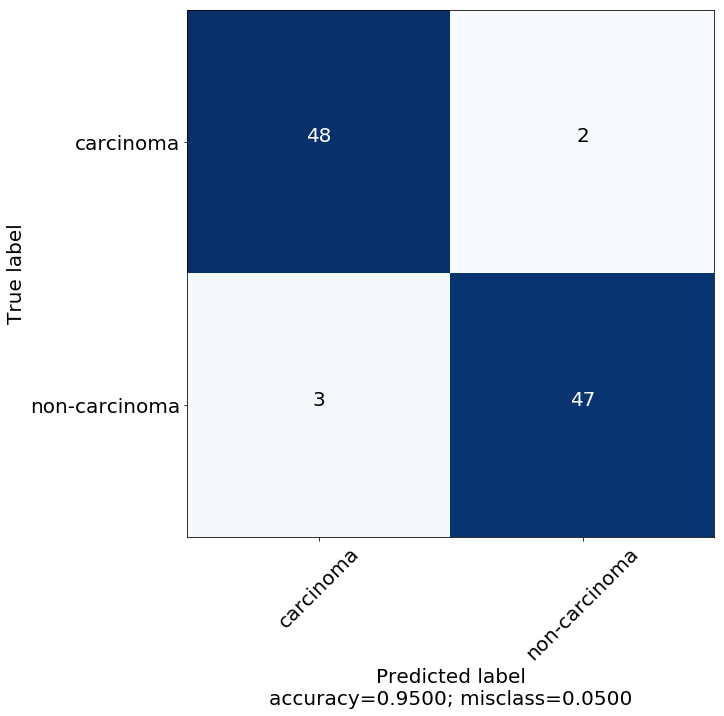

In [20]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[48  2]
 [ 3 47]]
               precision    recall  f1-score   support

non-carcinoma       0.94      0.96      0.95        50
    carcinoma       0.96      0.94      0.95        50

    micro avg       0.95      0.95      0.95       100
    macro avg       0.95      0.95      0.95       100
 weighted avg       0.95      0.95      0.95       100



In [22]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  94.11764705882352
Specificity :  95.91836734693877


In [26]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.9501800720288115


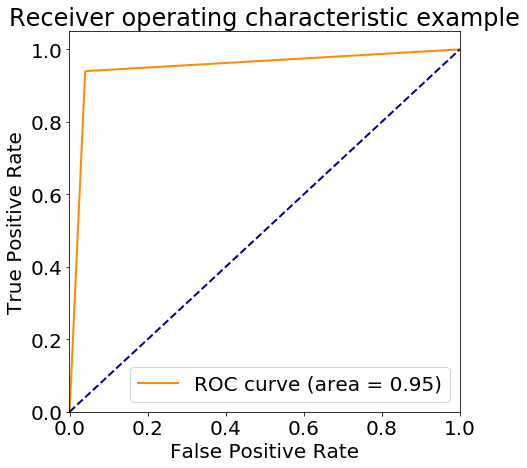

In [27]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [28]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

100/100 [==============================] - 0s 150us/step


In [29]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [30]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

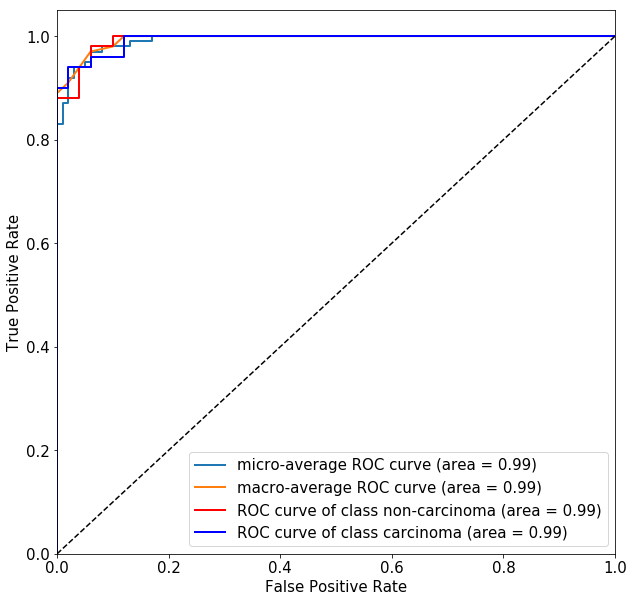

In [31]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [32]:
tn, fp, fn, tp = cm.ravel()

In [33]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.95
Precision: 0.9591836734693877
Recall: 0.94
tp: 47
fp: 2
tn: 48
fn: 3


In [34]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.9494949494949495


In [35]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.9494949494949494


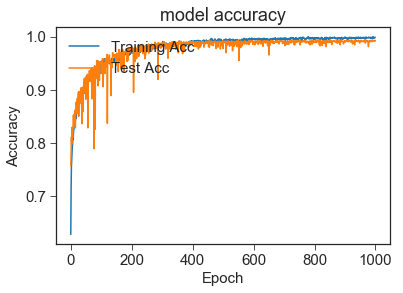

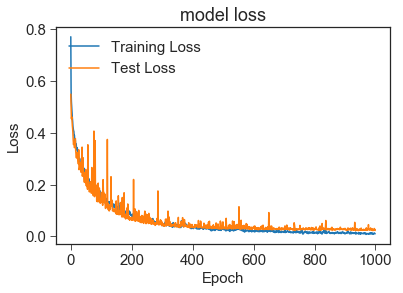

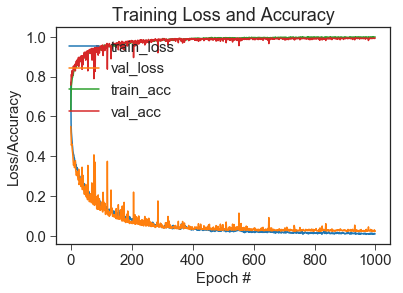

In [36]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")